In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import linear_model

data = pd.read_csv("online_classroom.csv")


In [2]:
target = 'falsexam'
treatment = 'format_ol'

In [3]:
# Efecto a primera vista
data.query("format_ol == 1").falsexam.mean()

73.63526308510637

In [4]:
data.query("format_ol != 1").falsexam.mean()

77.85552344978166

Por propiedades de la regresión lineal (que no veremo en este curso de momento) las $\beta_i$ son realmente un promedio de las variables categoricas.

Quiere decir que podríamos usar una regresión para probar hipotesis

In [5]:
# Regresion
model = smf.ols("falsexam ~ format_ol", data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               falsexam   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     8.938
Date:                Tue, 11 Feb 2025   Prob (F-statistic):            0.00301
Time:                        20:25:50   Log-Likelihood:                -1246.9
No. Observations:                 323   AIC:                             2498.
Df Residuals:                     321   BIC:                             2505.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     77.8555      0.762    102.235      0.0

El modelo nos da el coeficiente, que es exactamente igual a la diferencia de los promedios

#### Intentando estimar la variabilidad de $\beta$, resampleo

In [6]:
coeficiente = []
for i in range(500):
    my_data = data.sample(len(data), replace=True)
    X = my_data[[treatment]]
    y = my_data[target]
    model = linear_model.LinearRegression().fit(X, y)
    coeficiente.append(model.coef_[0])

In [7]:
coeficiente;

In [8]:
np.std(coeficiente)

1.7138478215374664

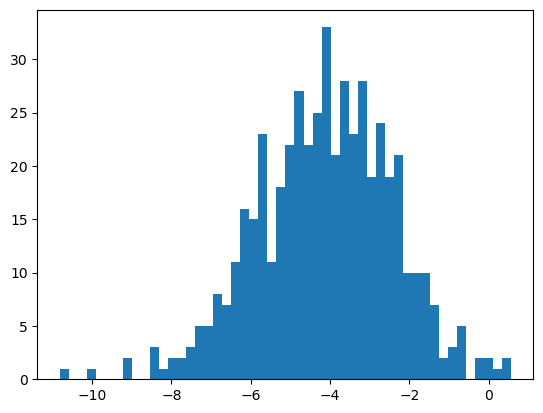

In [9]:
plt.hist(coeficiente, bins=50);

#### Varianza de los residuos
$\hat{\sigma^2} = \frac{\sum(y - \hat{y})^2}{n - p - 1}$

Donde:

$n$  es el total de datos

$p$ total de variables

Esto sería simplemente el error cuadrático promedio de mi modelo 

#### Variabilidad de lo que usas para predecir 

Suma de los cuadrados de X  =$\sum (x - \hat{x_i})^2$

Esto es la varianza de tu predictor pero sin dividir entre n

#### Varianza del coeficiente $\beta$

$SE(\beta)$ = $\sqrt{\frac{\hat{\sigma^2}}{\sum (x - \hat{x_i})^2}}$


In [10]:
# p son grados de libertad (número de variables)
X = data[['format_ol']]
y = data['falsexam']
model = linear_model.LinearRegression().fit(X, y)

predicciones = model.predict(X)

residuos = np.sum((y - predicciones)**2) / (len(y) - 1 - 1)

suma_cuadrada = np.sum((X - np.mean(X))**2)

se = np.sqrt(residuos / suma_cuadrada)

se

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


format_ol    1.411646
dtype: float64

### Estadístico t

$t = \lvert \frac{\beta_i}{SE(\beta_i)} \rvert$

nos dice cuántas desviaciones estándar $\beta$ está  lejos de cero.

Ojo: la distibución $t$ es simetrica y puede ser del lado derecho o izquierdo, habría que multiplicar este p value por dos



In [14]:
t = np.abs(model.coef_[0] / se)
t

format_ol    2.989602
dtype: float64

P - Value

$2 * P(T > \lvert t \rvert)$

Si bien el estadístico t nos dice cuantas desviaciones estandard está por arriba de 0, puede ser a cualquier lado 

- Si t es muy positivo, queremos ver la probabilidad de obtener un valor tan alto o mayor.

- Si t es muy negativo, queremos ver la probabilidad de obtener un valor tan bajo o menor.

In [17]:
2 * (1 - stats.t.cdf(abs(t), df=len(data)))[0]

0.003007861336434381

P-value

1 - stats.t.cdf(abs(t), df=len(data))

Intervalos de confianza

In [19]:
model.coef_[0] - 2*se

format_ol   -7.043552
dtype: float64

In [20]:
model.coef_[0] + 2*se

format_ol   -1.396968
dtype: float64

### Usando stats model 

Sklearn no nos da el intervalo de confianza ni el valor P de los estimados, afortunadamente statsmodel si nos lo puede dar

### Volviendo al ejemplo de las casas

median_income y total_rooms

In [11]:
df = pd.read_csv('housing.csv')